<a href="https://colab.research.google.com/github/ljy9969/Study/blob/master/colab(0421)cat_dog_small_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
__________________

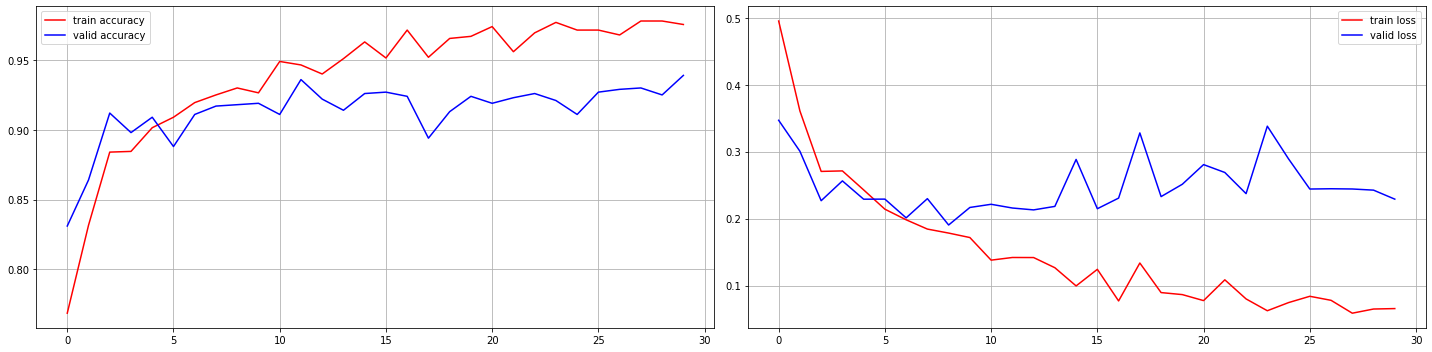

In [1]:
# 이미지 증식을 이용한 전이학습(Fine Tuning)

import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

train_dir = '/content/drive/MyDrive/Colab 멀캠 이지연/cat_dog_small/train'
valid_dir = '/content/drive/MyDrive/Colab 멀캠 이지연/cat_dog_small/validation'

train_datagen = ImageDataGenerator(rescale=1/255,
                                  rotation_range=30,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                   classes=['cats', 'dogs'],
                                                   target_size=(150,150),
                                                   batch_size=20,
                                                   class_mode='binary') # 다중분류 시에는 categorical

valid_generator = valid_datagen.flow_from_directory(valid_dir,
                                                   classes=['cats', 'dogs'],
                                                   target_size=(150,150),
                                                   batch_size=20,
                                                   class_mode='binary') # 다중분류 시에는 categorical

# Pretrained Network
model_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150,150,3))

# VGG16(Conv layer) 안에 있는 모든 prams를 동결. Non-trainable params: 0 -> 14,714,688
model_base.trainable = False

# print(model_base.summary())

# model 생성
model = Sequential()
model.add(model_base)
model.add(Flatten(input_shape=(4*4*512,))) # 4차원인 activation map을 2차원으로 펴줌(이미지 3차원을 1차원으로)
model.add(Dense(units=256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(units=1, activation='sigmoid'))

# print(model.summary())

model.compile(optimizer=Adam(learning_rate=1e-4),
             loss='binary_crossentropy',
             metrics=['accuracy'])

history = model.fit(train_generator,
                   steps_per_epoch=100, # 2000 / 20
                   epochs=30,
                   validation_data=valid_generator,
                   validation_steps=50,
                   verbose=1) # verbose=0(Print None), 1(연산 전체), 2(loss만), 3(epochs만)

########### 여기까지 수행하면 classifier가 학습됨 ###########

model_base.trainable = True # VGG16(Conv layer) 동결 해체

for layer in model_base.layers:
  if layer.name in ['block5_conv1', 'block5_conv2', 'block5_conv3']:
    layer.trainable = True # 동결 해제
  else:
    layer.trainable = False # 동결

model.compile(optimizer=Adam(learning_rate=1e-5),
             loss='binary_crossentropy',
             metrics=['accuracy'])

history = model.fit(train_generator,
                   steps_per_epoch=100, # 2000 / 20
                   epochs=30,
                   validation_data=valid_generator,
                   validation_steps=50,
                   verbose=1)                             # val_accuracy: 0.9390

# history 객체로 그래프 그려보기
import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
valid_acc = history.history['val_accuracy']

train_loss = history.history['loss']
valid_loss = history.history['val_loss']

figure = plt.figure(figsize=(20,5))
ax1 = figure.add_subplot(1,2,1)
ax2 = figure.add_subplot(1,2,2)

ax1.plot(train_acc, color='r', label='train accuracy')
ax1.plot(valid_acc, color='b', label='valid accuracy')
ax1.legend()
ax1.grid()

ax2.plot(train_loss, color='r', label='train loss')
ax2.plot(valid_loss, color='b', label='valid loss')
ax2.legend()
ax2.grid()

plt.tight_layout()
plt.show()